In [1]:
import os
import datetime
import numpy as np

In [2]:
import tensorflow as tf
import tf_keras
from tf_keras.layers import Input,Dense
from tf_keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Conv2DTranspose,concatenate
from tf_keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tf_keras.callbacks import LearningRateScheduler,ModelCheckpoint
import tf_keras.backend as K
from tf_keras.losses import categorical_crossentropy
from tf_keras.preprocessing.image import ImageDataGenerator
from tf_keras import layers

In [33]:
import tensorflow as tf
from tf_keras.layers import Input,Dense
from tf_keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Conv2DTranspose,Conv3D,DepthwiseConv2D,DepthwiseConv1D
from tf_keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tf_keras.callbacks import LearningRateScheduler,ModelCheckpoint
import tf_keras.backend as K
from tf_keras.preprocessing.image import ImageDataGenerator
from tf_keras import layers

In [4]:
import tempfile
import tensorflow_model_optimization as tfmot
from tf_keras.applications.mobilenet_v2 import MobileNetV2


In [5]:
import glob
filename = glob.glob(r'DeepLearningBasedTBDiagnosis/dataset/TBX11K/imgs/tb/*.*')
print(len(filename))
filename = glob.glob(r'DeepLearningBasedTBDiagnosis/dataset/TBX11K/imgs/sick/*.*')
print(len(filename))
filename = glob.glob(r'DeepLearningBasedTBDiagnosis/dataset/TBX11K/imgs/health/*.*')
print(len(filename))

0
0
0


In [ ]:
BATCH_SIZE = 16
IMG_SIZE = (256,256)

train_dir = 'dataset/TBX11K/imgs/train/'
test_dir = 'dataset/TBX11K/imgs/test/'

In [7]:
from dataset import define_data
from sklearn.preprocessing import LabelBinarizer
train = LabelBinarizer()

In [8]:
from dataset import define_data
train_data, train_y = define_data(train_dir,IMG_SIZE)
target_val = train.fit_transform(train_y)

loading 500th image for class health
loading 500th image for class sick
loading 500th image for class tb


In [9]:
test_size=0.15
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np.array(train_data, ),target_val,test_size=test_size,random_state=42)

In [10]:
back_net = MobileNetV2
net = "MobileNetV2"

In [94]:
def model(input_shape):
    inputs = Input(shape=input_shape,name="input_image")
    base_model = back_net(input_tensor = inputs, weights="imagenet", include_top=False, alpha=0.35)
    #base_model.trainable=False
    x=base_model.output
    x=GlobalAveragePooling2D(name="gap")(x)
    output=Dense(3,activation="softmax")(x)
    return tf_keras.Model(inputs,output)

In [95]:
#the steps of this are vaguely unclear to me - i.e., do I need to compile again? is load_weights sufficient? time to research
base_model = model(input_shape=(256,256,3))
base_model.load_weights('mobilnet-output/class_weights.06-0.96.weights.h5')
base_model.compile(optimizer=tf_keras.optimizers.Adam(),
              loss=tf_keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

In [96]:
batch_size = 16
epochs = 10
#test_size exists
image_num = x_train.shape[0] * (1-test_size)
end_step = np.ceil(image_num / batch_size).astype(np.int32) * epochs
print(image_num, end_step)

1677.8999999999999 1050


In [102]:
pruning_params = {
    "pruning_schedule" : tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.2,
        begin_step=1,
        end_step=end_step
    )
}

In [99]:
def apply_pruning(layer):
    if isinstance(layer, tf_keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

In [ ]:
prune_model = tfmot.sparsity.keras.prune_low_magnitude(base_model, **pruning_params)

In [104]:
prune_model.compile(
    optimizer=tf_keras.optimizers.Adam(),
    loss=tf_keras.losses.CategoricalCrossentropy(),
    metrics=['categorical_accuracy']
)

In [30]:
filepath=f'{back_net.__name__}/pruned/class_weights.{{epoch:02d}}-{{val_loss:.2f}}.weights.h5'

In [ ]:
callbacks = [
    tf_keras.callbacks.ModelCheckpoint(
        filepath=filepath,
        save_best_only=True,save_weights_only=True,verbose=1),
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir="./logs")
]

In [106]:
prune_model.fit(
    x=x_train,
    y=y_train,
    validation_split=test_size,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
)

Epoch 1/10
105/105 [==============================] - 136s 591ms/step - loss: 0.2368 - categorical_accuracy: 0.9201 - val_loss: 1.6217 - val_categorical_accuracy: 0.7710
Epoch 2/10
105/105 [==============================] - 52s 498ms/step - loss: 0.1247 - categorical_accuracy: 0.9577 - val_loss: 8.6124 - val_categorical_accuracy: 0.4310
Epoch 3/10
105/105 [==============================] - 49s 464ms/step - loss: 0.0929 - categorical_accuracy: 0.9690 - val_loss: 4.3840 - val_categorical_accuracy: 0.4579
Epoch 4/10
105/105 [==============================] - 62s 588ms/step - loss: 0.0648 - categorical_accuracy: 0.9756 - val_loss: 7.4492 - val_categorical_accuracy: 0.4276
Epoch 5/10
105/105 [==============================] - 59s 554ms/step - loss: 0.0299 - categorical_accuracy: 0.9881 - val_loss: 0.7539 - val_categorical_accuracy: 0.8316
Epoch 6/10
105/105 [==============================] - 53s 506ms/step - loss: 0.0253 - categorical_accuracy: 0.9952 - val_loss: 5.1259 - val_categorical_ac

In [107]:
_,model_for_prune_accuracy = prune_model.evaluate(x_test,y_test)
print(model_for_prune_accuracy)

11/11 [==============================] - 3s 234ms/step - loss: 1.2276 - categorical_accuracy: 0.8338
0.8338108658790588


In [108]:
predictions = prune_model.predict(x_test)

11/11 [==============================] - 7s 217ms/step


In [109]:
preds = np.zeros((y_test.shape[0]))
for i,p in enumerate(predictions):
    l = np.argmax(p)
    preds[i] = l

y = [np.argmax(yy) for yy in y_test]

In [110]:
model_for_export = tfmot.sparsity.keras.strip_pruning(prune_model)

In [111]:
from sklearn.metrics import classification_report
print(classification_report(y,preds))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       121
           1       1.00      0.53      0.69       104
           2       0.84      0.93      0.88       124

    accuracy                           0.83       349
   macro avg       0.87      0.82      0.81       349
weighted avg       0.86      0.83      0.82       349



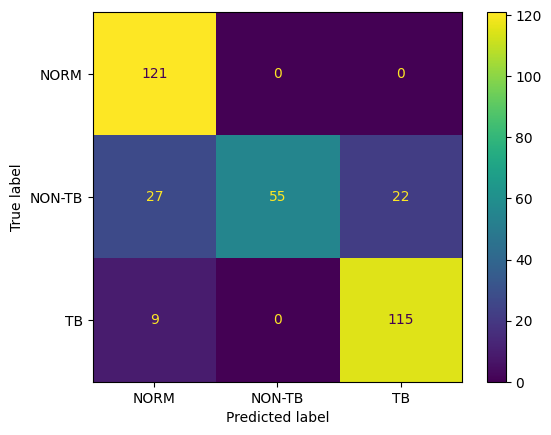

In [112]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y,preds,labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["NORM","NON-TB","TB"])
disp.plot()
plt.savefig(f"{back_net.__name__}-prune-confusionmatrix.png")
plt.show()